# ``eBOSS`` Quasar Luminosity Function

Initiate notebook.

In [1]:
import os
import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
harmony_sty = matplotlib.rc_params_from_file("./harmony.mplstyle", use_default_template=False)

plt.style.use(harmony_sty)

sns.set(style='ticks', font='serif')

## Luminosity function measurements

Load measurements from data files into a dictionary.

In [3]:
raw_measurements = np.genfromtxt("data/input/luminosity_function_in_redshift_bins.txt").T

with open("data/input/luminosity_function_in_redshift_bins.txt", 'r') as data_file:
    observables = tuple(map(
        lambda var_name: var_name.strip(" "), 
        data_file.readline().strip("#").strip("\n").split(",")
    ))

measurements = np.zeros_like(raw_measurements)
for var_idx, var_name in enumerate(observables):
    if var_name.startswith('Phi'):
        measurements[var_idx] = 10**raw_measurements[var_idx]
    elif var_name.startswith('d_Phi'):
        measurements[var_idx] = (10**raw_measurements[var_idx] - 1) * 10**raw_measurements[var_idx-1]
    else:
        measurements[var_idx] = raw_measurements[var_idx]
    
luminosity_function_data = dict(zip(observables, measurements))

Extract redshift bins from measurement labels.

In [4]:
redshift_bin_labels = tuple(map(
    lambda redshift_range: r"${}$".format(redshift_range),
    [
        var_name.split("z_")[-1].replace("_", "<z<")
        for col_no, var_name in enumerate(luminosity_function_data) if col_no % 2 == 1
    ]
))

redshift_bin_centres = tuple(map(
    lambda redshift_range: np.mean(list(map(lambda endpoint: float(endpoint), redshift_range))),
    [
        var_name.split("z_")[-1].split("_")
        for col_no, var_name in enumerate(luminosity_function_data) if col_no % 2 == 1
    ]
))

redshift_bins = dict(zip(redshift_bin_labels, redshift_bin_centres))

## Pure luminosity evolution model

In [5]:
def pure_luminosity_evolution_model(magnitude_in_g_band, redshift, redshift_pivot=2.2, **model_parameters):
    """Evaluate the parametric pure luminosity evolution function model for given normalised magnitude and redshift.
    
    Parameters
    ----------
    magnitude_in_g_band : float
        Magnitude in *g*-band normalised to the value at redshift 2.
    redshift : float
        Quasar redshift.
    redshift_pivot : float, optional
        Pivot redshift.
    **model_parameters
        Model parameters.
    
    Returns
    -------
    comoving_density : float :class:`numpy.ndarray`
        Predicted qausar comoving number density per unit magnitude normalised to redshift 2 in *g*-band.
    
    """    
    # Re-definitions.
    M_g, z, z_p = magnitude_in_g_band, redshift, redshift_pivot
    
    # Determine the redshift end.
    if z <= z_p:
        subscript = '\\textrm{{{}}}'.format('l')
    else:
        subscript = '\\textrm{{{}}}'.format('h') 
    
    # Set parameters.
    Phi_star = 10**model_parameters['\\log\\Phi^\\ast']
    M_g_star_p = model_parameters['M^\\ast_g(z_\\textrm{pivot})']
    
    alpha, beta = model_parameters['\\alpha_{}'.format(subscript)], model_parameters['\\beta_{}'.format(subscript)]
    k_1, k_2 = model_parameters['k_{{1{}}}'.format(subscript)], model_parameters['k_{{2{}}}'.format(subscript)]
    
    # Evaluate the model prediction.
    exponent_magnitude_factor = M_g - (M_g_star_p - 2.5*(k_1 * (z - z_p) + k_2 * (z - z_p)**2))
    faint_power_law = 10 ** (0.4*(alpha + 1) * exponent_magnitude_factor)
    bright_power_law = 10 ** (0.4*(beta + 1) * exponent_magnitude_factor)
    
    luminosity_function_density = Phi_star / (faint_power_law + bright_power_law)
    
    return luminosity_function_density

Load best-fitting model parameters.

In [6]:
with open("data/input/pure_luminosity_evolution_parameters.txt", 'r') as parameter_file:
    parameters_PLE = tuple(map(
        lambda var_name: var_name.strip(" "), 
        parameter_file.readline().strip("#").strip("\n").split(",")
    ))
    estimates_PLE = tuple(map(
        lambda value: float(value), 
        parameter_file.readline().split(",")
    ))
    
model_fits_PLE = dict(zip(parameters_PLE, estimates_PLE))

## Luminosity function model comparison

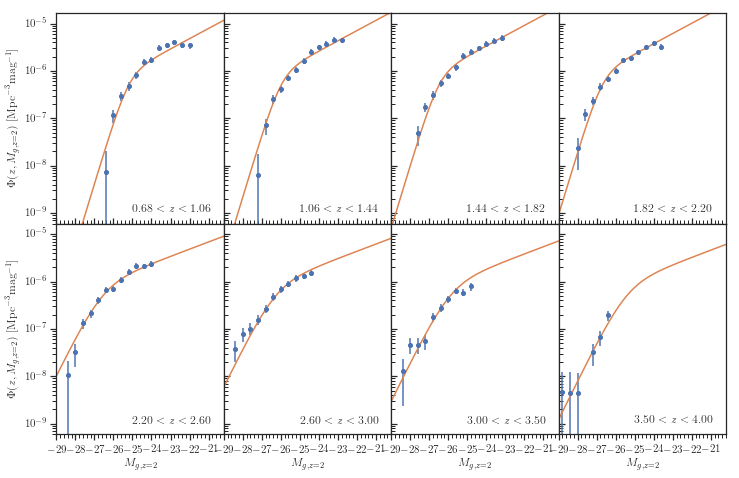

In [7]:
plt.figure("Luminosity function in redshift bins", figsize=(12, 7.75))

NUM_ROW, NUM_COL = 2, 4
ROW_SPAN, COL_SPAN = 4, 3

MAGNITUDE_RANGE = -29.0, -20.2
DENSITY_RANGE = 10**(-9.225), 10**(-4.775)

magnitude_points = np.linspace(*MAGNITUDE_RANGE, num=101)

for bin_idx, (bin_label, bin_redshift) in enumerate(redshift_bins.items()):
    
    row_idx, col_idx = bin_idx // NUM_COL, bin_idx % NUM_COL
    
    ax = plt.subplot2grid(
        (NUM_ROW*ROW_SPAN, NUM_COL*COL_SPAN), 
        (row_idx*ROW_SPAN, col_idx*COL_SPAN), 
        rowspan=ROW_SPAN, 
        colspan=COL_SPAN
    )
    
    plt.errorbar(
        luminosity_function_data['magnitude'],
        luminosity_function_data[observables[2*bin_idx+1]], 
        yerr=luminosity_function_data[observables[2*bin_idx+2]],
        fmt='o',
        markersize=4.,
        capsize=0.
    )
    plt.plot(
        magnitude_points, 
        pure_luminosity_evolution_model(magnitude_points, bin_redshift, **model_fits_PLE)
    )
    
    plt.xscale('linear')
    plt.xlim(*MAGNITUDE_RANGE)
    
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1.))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.2))
    if row_idx + 1 < NUM_ROW:
        plt.tick_params(axis='x', which='both', direction='in', labelbottom=False, labelsize=2)
    else:
        plt.xlabel(r"$M_{g,z=2}$")
        
    plt.yscale('log')    
    plt.ylim(*DENSITY_RANGE)
    
    if col_idx > 0:
        plt.tick_params(axis='y', which='both', direction='in', labelleft=False, labelsize=2)
    else:
        plt.ylabel(r"$\Phi(z,M_{g,z=2})$ [$\textrm{Mpc}^{-3} \textrm{mag}^{-1}$]")
    
    plt.title(bin_label, loc='right', position=(0.925, 0.025))

plt.subplots_adjust(hspace=0, wspace=0)